In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
import tensorflow as tf
tf.random.set_seed(1234)

from numpy.random import seed
tf.random.set_seed(1)
seed(1)



In [3]:
! pwd

/content


In [4]:
! ls

sample_data


In [5]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls

drive  sample_data


In [8]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [9]:
link = 'https://drive.google.com/file/d/1bvbNnP9h-YO43DYHvkJodJC1fkEkt0Co/view?usp=sharing' # The shareable link

In [10]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

sharing


In [15]:
downloaded = drive.CreateFile({'id':id}) 
import pandas as pd 
import io 
link = 'https://drive.google.com/file/d/1bvbNnP9h-YO43DYHvkJodJC1fkEkt0Co/view?usp=sharing'

import pandas as pd 

# to get the id part of the file 
id = link.split("/")[-2] 

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv') 

(train_x) = pd.read_csv('train.csv') 
(train_y) = pd.read_csv('train.csv') 
print(train_x)


# Dataset is now stored in a Pandas Dataframe

              date  store  item  sales
0       2013-01-01      1     1     13
1       2013-01-02      1     1     11
2       2013-01-03      1     1     14
3       2013-01-04      1     1     13
4       2013-01-05      1     1     10
...            ...    ...   ...    ...
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82

[913000 rows x 4 columns]


In [16]:
train_x.shape

(913000, 4)

In [17]:
train_x.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

In [18]:
train_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [19]:
link = 'https://drive.google.com/file/d/1ow00b0VvoEQ4aUMbCwncvwYK4AAqgH_2/view?usp=sharing' # The shareable link

In [20]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

sharing


In [21]:
downloaded = drive.CreateFile({'id':id}) 
import pandas as pd 
import io 
link = 'https://drive.google.com/file/d/1ow00b0VvoEQ4aUMbCwncvwYK4AAqgH_2/view?usp=sharing'

import pandas as pd 

# to get the id part of the file 
id = link.split("/")[-2] 

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv') 

test_x = pd.read_csv('test.csv') 
test_y = pd.read_csv('test.csv') 
print(test_x)


# Dataset is now stored in a Pandas Dataframe

          id        date  store  item
0          0  2018-01-01      1     1
1          1  2018-01-02      1     1
2          2  2018-01-03      1     1
3          3  2018-01-04      1     1
4          4  2018-01-05      1     1
...      ...         ...    ...   ...
44995  44995  2018-03-27     10    50
44996  44996  2018-03-28     10    50
44997  44997  2018-03-29     10    50
44998  44998  2018-03-30     10    50
44999  44999  2018-03-31     10    50

[45000 rows x 4 columns]


In [22]:
test_x.shape

(45000, 4)

In [23]:
test_x.head()

id        date  store  item
0   0  2018-01-01      1     1
1   1  2018-01-02      1     1
2   2  2018-01-03      1     1
3   3  2018-01-04      1     1
4   4  2018-01-05      1     1

In [24]:
test_y.info()
# Here we can see that there are no missing values in our dataframe. train file

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   date    45000 non-null  object
 2   store   45000 non-null  int64 
 3   item    45000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB


In [26]:
# calculating average
grand_avg = train_x.sales.mean()
print(f"The grand average of sales in this dataset is {grand_avg:.4f}")


The grand average of sales in this dataset is 52.2503


In [27]:
train_x = train_x.set_index('date')
train_x.head()

store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10

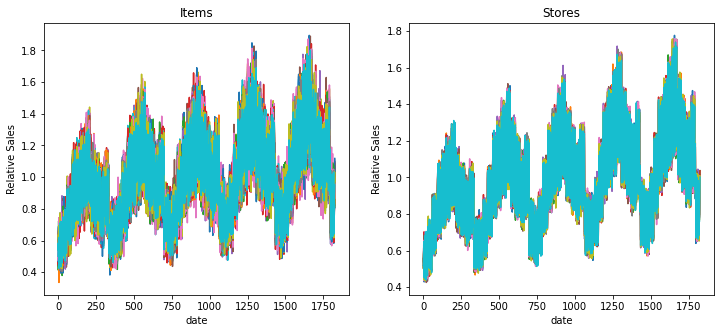

In [29]:
# sales of the year
agg_year_item = pd.pivot_table(train_x, index='date', columns='item',
                               values='sales', aggfunc=np.mean).values
agg_year_store = pd.pivot_table(train_y, index='date', columns='store',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item / agg_year_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("date")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_year_store / agg_year_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("date")
plt.ylabel("Relative Sales")
plt.show()

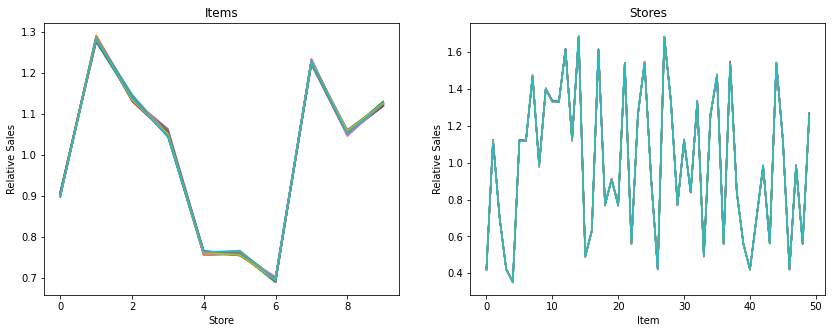

In [31]:
# with respect to item
agg_store_item = pd.pivot_table(train_x, index='store', columns='item',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(agg_store_item / agg_store_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Store")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_store_item.T / agg_store_item.T.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Item")
plt.ylabel("Relative Sales")
plt.show()

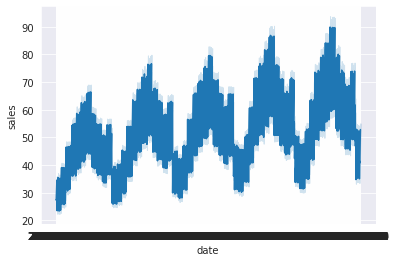

In [36]:

import warnings 
warnings.filterwarnings('ignore')

#Basic packages
import os
import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Time Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

color = sns.color_palette()
sns.set_style('darkgrid')
sns.lineplot(x="date",y="sales",legend="full",data=train_x)

<Figure size 432x288 with 0 Axes>

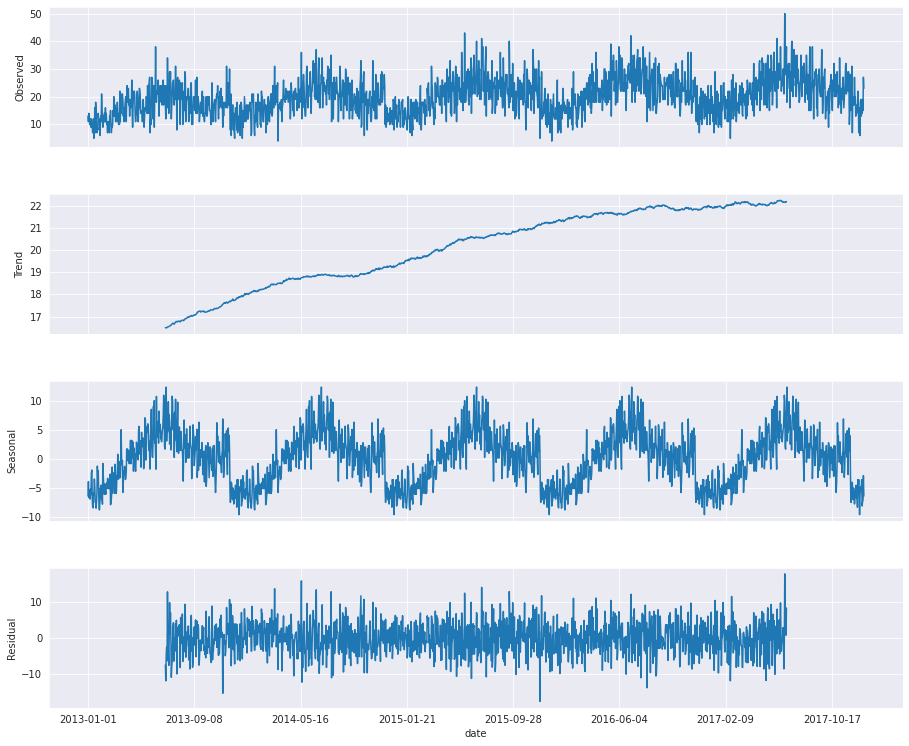

In [ ]:
# Lets decompose for data of smaller size. Here I will take data having item and store equal to 1.

train_item1 = train_x[train_x['item']==1]
train_final = train_item1[train_item1['store']==1]

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_final['sales'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

In [ ]:
# Make the time series stationary

first_diff = train_final.sales - train_final.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
print(first_diff.head())
#roll_stats(first_diff,window = 12, cutoff = 0.01)
#dickey_fuller_test(first_diff, window = 12)

date
2013-01-02   -2.0
2013-01-03    3.0
2013-01-04   -1.0
2013-01-05   -3.0
2013-01-06    2.0
Name: sales, dtype: float64


In [37]:
#Transform the data into a time series problem

def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [38]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	train_x, train_y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		train_x.append(seq_x)
		train_y.append(seq_y)
	return array(train_X), array(train_y)

In [41]:
def data_gen(num, in_shape):
    for i in range(num):
        train_x = np.random.rand(in_shape[0], in_shape[1])
        train_y = random.randint(0,2)
        yield x, y
        
def data_gen_all(num, in_shape, num_labels):
    train_x = np.zeros([num]+in_shape)
    train_y = np.zeros([num]+[num_labels])
    for i in range(num):
       train_x[i,:,:]= np.random.rand(in_shape[0], in_shape[1])
       test_x[i]= tf.one_hot(random.randint(0, num_labels), num_labels).numpy()
    return train_x, test_x
train = tf.data.Dataset.from_generator(
    generator=data_gen,
    output_types=(tf.float32, tf.int32))
#     output_shapes=(tf.TensorShape([None, INPUT_SHAPE[1]]), tf.TensorShape(None)),
#     output_shapes=(tf.TensorShape(INPUT_SHAPE), tf.TensorShape(()))


In [42]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [54]:
train_x = np.asarray(train_x)
train_y   = np.asarray(train_y)
train_x.shape

train_x = np.expand_dims(train_x, -1)
train_y   = np.expand_dims(train_y, -1)
train_x.shape

(913000, 3, 1)

In [56]:
if False:
    from tensorflow.python.keras.initializers import con2D

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [58]:
np.array(train_x, dtype=np.float)

array([[[ 1.],
        [ 1.],
        [13.]],

       [[ 1.],
        [ 1.],
        [11.]],

       [[ 1.],
        [ 1.],
        [14.]],

       ...,

       [[10.],
        [50.],
        [74.]],

       [[10.],
        [50.],
        [62.]],

       [[10.],
        [50.],
        [82.]]])

In [110]:
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
tf.convert_to_tensor(
    train_x, dtype=None, dtype_hint=None, name=None
)
np.array(train_x).astype("float32")
from sklearn import preprocessing

def convert(train_y):
    number = preprocessing.LabelEncoder()
    train_y['Date'] = number.fit_transform(data['Date'])
    train_y=train_y.fillna(-999) # fill holes with default value
    return train_y
history = model.fit(train_x, train_y, batch_size = 64, epochs = 7)

ValueError: ignored

In [89]:
#dr = 0.5 # dropout rate 
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, ZeroPadding2D
#from keras.layers import Convolution2D, MaxPooling2D
#from keras.utils import np_utils
#from keras import backend as K
#import keras
#import keras.models as models
#model = Sequential()
#model.add(ZeroPadding2D(padding=(0, 2)))
#model.add(Convolution2D(256, 1, 3,  activation="relu", name="conv1"))
#model.add(Dropout(dr))
#model.add(ZeroPadding2D((0, 2)))
#model.add(Convolution2D(80, 1, 3, activation="relu", name="conv2"))
#model.add(Dropout(dr))
#model.add(Flatten())
#model.add(Dense(256, activation='relu', name="dense1"))
#model.add(Dropout(dr))
#model.add(Activation('softmax'))
#model.compile(loss='categorical_crossentropy', optimizer='adam')
#model.fit(train_x, train_y, epochs = 7)

In [82]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=train_x.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer='adam')
model_mlp.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               400       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [95]:
#mlp_history = model_mlp.fit(train_x, train_y, validation_data=(test_x,test_y), epochs=epochs, verbose=2)
